<a href="https://colab.research.google.com/github/soyudea/StrokePredictionModel/blob/main/04_modelo_con_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import math
from seaborn import distplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from matplotlib.patches import split_path_inout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot

from sklearn.model_selection import GridSearchCV

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.metrics import roc_auc_score

**1. Cargar Dataset**

Se carga el dataset final luego del preprocesamiento. Se cargan los archivos Dataset.csv y y.csv

In [4]:
X = pd.read_csv('Dataset.csv', sep=",") 
y = pd.read_csv('y.csv', sep=",") 

X=X.drop(columns=['Unnamed: 0'])
y=y.drop(columns=['Unnamed: 0'])


**2. Generador de muestras sintéticas**

In [5]:
pca=PCA(n_components=30) 
pca.fit(X) #
X_pca=pca.transform(X)

In [6]:
ros = RandomOverSampler(random_state=42, sampling_strategy=1.0)                          
Xres, yres = ros.fit_resample(X_pca, y)
Xtrain, Xtst, ytrain, ytst = train_test_split(Xres,yres, test_size=0.1) #Se toma el 90 % de los datos para Entrenar
print (Xtrain.shape, ytrain.shape, Xtst.shape, ytst.shape)
X=Xtrain
y=ytrain

(26409, 30) (26409, 1) (2935, 30) (2935, 1)


**3. Cálculo pesos de la clase Parámetro que se usa para minimizar el efecto del desbalance del dataset**

In [7]:
def dar_peso_clase():
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state = 17)
  Number_Muestras_por_Clase = ytrain.value_counts()
  Number_Muestras_por_Clase = Number_Muestras_por_Clase.sort_index(axis = 0, ascending = True)
  Numero_de_Clases = len(Number_Muestras_por_Clase.index)
  Peso_por_Clase = len(ytrain)/(Numero_de_Clases*Number_Muestras_por_Clase)
  return Peso_por_Clase

**4. Modelo de clasificación random Forest Entrenamiento con el 90 % de los datos**

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [8]:
weight = dar_peso_clase() 
kf = KFokf = KFold(n_splits=10, random_state = True,shuffle=True)

X_test =0
Y_test =0

#warm_start mejoro la velocidad de ejecucion, mejoró la metrica
classifier = RandomForestClassifier(min_samples_split=10,
                                    ccp_alpha=0.000001,
                                    criterion='gini',
                                    class_weight = {0: weight[0], 1: weight[1]},
                                    random_state=True,max_features ="sqrt",
                                    warm_start=True,min_impurity_decrease=0.000005)

for train_index, test_index in kf.split(X):
    
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    modelo = classifier.fit(Xtrain, ytrain)
    ypred = modelo.predict(Xtest)

    print()
    print(confusion_matrix(ytest, ypred))
    print(classification_report(ytest, ypred, digits =4, labels=[0,1]))
    s = roc_auc_score(ytest, modelo.predict(Xtest))
    print(f'Best val auc: {s: .4f}')

<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)



[[ 951  335]
 [ 171 1184]]
              precision    recall  f1-score   support

           0     0.8476    0.7395    0.7899      1286
           1     0.7795    0.8738    0.8239      1355

    accuracy                         0.8084      2641
   macro avg     0.8135    0.8067    0.8069      2641
weighted avg     0.8126    0.8084    0.8073      2641

Best val auc:  0.8067


<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(



[[ 982  335]
 [ 158 1166]]
              precision    recall  f1-score   support

           0     0.8614    0.7456    0.7993      1317
           1     0.7768    0.8807    0.8255      1324

    accuracy                         0.8133      2641
   macro avg     0.8191    0.8131    0.8124      2641
weighted avg     0.8190    0.8133    0.8125      2641

Best val auc:  0.8131


<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(



[[ 994  343]
 [ 144 1160]]
              precision    recall  f1-score   support

           0     0.8735    0.7435    0.8032      1337
           1     0.7718    0.8896    0.8265      1304

    accuracy                         0.8156      2641
   macro avg     0.8226    0.8165    0.8149      2641
weighted avg     0.8233    0.8156    0.8147      2641

Best val auc:  0.8165


<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(



[[ 958  349]
 [ 162 1172]]
              precision    recall  f1-score   support

           0     0.8554    0.7330    0.7895      1307
           1     0.7705    0.8786    0.8210      1334

    accuracy                         0.8065      2641
   macro avg     0.8130    0.8058    0.8052      2641
weighted avg     0.8125    0.8065    0.8054      2641

Best val auc:  0.8058


<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)



[[ 989  342]
 [ 147 1163]]
              precision    recall  f1-score   support

           0     0.8706    0.7431    0.8018      1331
           1     0.7728    0.8878    0.8263      1310

    accuracy                         0.8148      2641
   macro avg     0.8217    0.8154    0.8140      2641
weighted avg     0.8221    0.8148    0.8139      2641

Best val auc:  0.8154


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)



[[ 990  316]
 [ 158 1177]]
              precision    recall  f1-score   support

           0     0.8624    0.7580    0.8068      1306
           1     0.7883    0.8816    0.8324      1335

    accuracy                         0.8205      2641
   macro avg     0.8254    0.8198    0.8196      2641
weighted avg     0.8250    0.8205    0.8198      2641

Best val auc:  0.8198



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)


[[1004  349]
 [ 165 1123]]
              precision    recall  f1-score   support

           0     0.8589    0.7421    0.7962      1353
           1     0.7629    0.8719    0.8138      1288

    accuracy                         0.8054      2641
   macro avg     0.8109    0.8070    0.8050      2641
weighted avg     0.8121    0.8054    0.8048      2641

Best val auc:  0.8070


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(



[[ 979  315]
 [ 170 1177]]
              precision    recall  f1-score   support

           0     0.8520    0.7566    0.8015      1294
           1     0.7889    0.8738    0.8292      1347

    accuracy                         0.8164      2641
   macro avg     0.8205    0.8152    0.8153      2641
weighted avg     0.8198    0.8164    0.8156      2641

Best val auc:  0.8152

[[ 953  359]
 [ 170 1159]]
              precision    recall  f1-score   support

           0     0.8486    0.7264    0.7828      1312
           1     0.7635    0.8721    0.8142      1329

    accuracy                         0.7997      2641
   macro avg     0.8061    0.7992    0.7985      2641
weighted avg     0.8058    0.7997    0.7986      2641

Best val auc:  0.7992

[[1013  328]
 [ 134 1165]]
              precision    recall  f1-score   support

           0     0.8832    0.7554    0.8143      1341
           1     0.7803    0.8968    0.8345      1299

    accuracy                         0.8250      2640


<ipython-input-8-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


**5. Curva ROC: RandomForest**


Sin entrenar: ROC AUC=0.500
Algoritmo RandomForest: ROC AUC=0.826




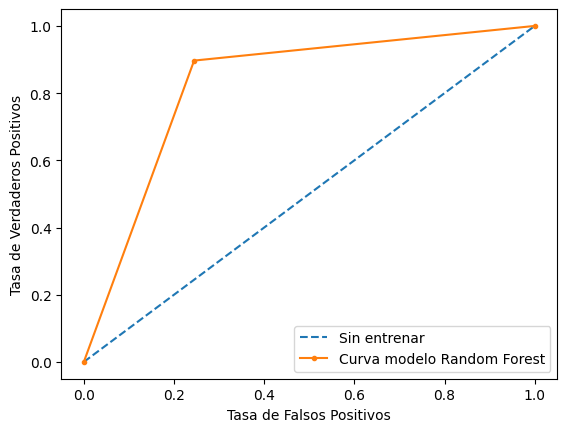

In [9]:
classes = classifier.predict(Xtest)
ns_probs = [0 for _ in range(len(ytest))]
ns_auc = roc_auc_score(ytest, ns_probs,average='weighted')
classifier_auc = roc_auc_score(ytest,classes,average='weighted')
#aps = average_precision_score(ytest, ns_probs)
print()
#print("Average_presicion_score "+str(aps))
print('Sin entrenar: ROC AUC=%.3f' % (ns_auc))
print('Algoritmo RandomForest: ROC AUC=%.3f' % (classifier_auc))
print()
classifier_probs = classes[:]
ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
classifier_fpr,classifier_tpr, _ = roc_curve(ytest, classifier_probs)
print()
pyplot.plot(classifier_fpr,classifier_tpr, marker='.', label='Curva modelo Random Forest')
pyplot.xlabel('Tasa de Falsos Positivos')
pyplot.ylabel('Tasa de Verdaderos Positivos')
pyplot.legend()
pyplot.show()